<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_postprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install memory_profiler

CPU times: user 589 ms, sys: 170 ms, total: 759 ms
Wall time: 1min 25s


In [3]:
%%time
import datetime
import glob
import shutil
from math import sqrt
import os
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline
%load_ext memory_profiler

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 950 ms, sys: 147 ms, total: 1.1 s
Wall time: 2.83 s


In [4]:
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/120/1,Cluster Workers: 1 Cores: 2 Memory: 13.66 GB


In [0]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

In [0]:
# @dask.delayed
def read_and_concatenate_parquets(prefix, path=path_output):
  L = []
  files = glob.glob(os.path.join(path_output, prefix))# output_scenario_0_step_0.parquet
  for file in files:
    pqt = dd.read_parquet(file)
    L.append(pqt)
  df = dd.concat(L)
  return df

In [0]:
def count_fid_occurences(df):
  count = df.groupby(['source'])['count'].sum().compute()
  count_df = count.to_frame()
  # count_df['count'] = count
  # count_df['source'] = count_df.index
  # count_df = count_df.reset_index()
  # count_df = count_df.drop(columns='index')
  return count_df

In [0]:
def load_shapefile(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path, file_name), bbox=bbox)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    # gdf.plot(column='IgnProb_bl', cmap='hsv', legend=True)
    return gdf_buildings

In [0]:
def merge_coordinates_export_shape(ddf, gdf, name_output):
  gdf = gdf[['TARGET_FID', 'geometry']]
  df = pd.DataFrame(gdf)
  # ddf = ddf.compute()
  df_merge = ddf.merge(df, how='left', left_on='source', right_on='TARGET_FID')
  gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry')
  gdf_merge.plot(column='count', cmap='seismic', legend=True)
  gdf_merge.to_file(os.path.join(path_output, "shapefiles", name_output + ".shp"))
  return gdf_merge

In [0]:
# %%time
# %memit
df = read_and_concatenate_parquets("output_scenario*")
count_df = count_fid_occurences(df)

In [43]:
gdf = load_shapefile("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole

Shapefile extent : [1740507.1581502  5420048.34765005 1755776.95354986 5443033.48509979]
Asset loaded : 74245


peak memory: 668.75 MiB, increment: 0.24 MiB
CPU times: user 37.1 s, sys: 3.01 s, total: 40.1 s
Wall time: 50.4 s


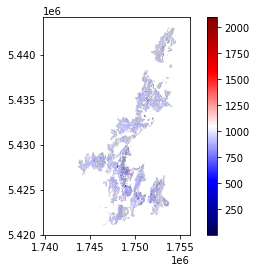

In [48]:
%%time
%memit
gdf_count = merge_coordinates_export_shape(count_df, gdf, "burned_buildings")

In [0]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

# Create the blank plot
p = figure(plot_height = 600, plot_width = 600, 
           title = 'Histogram of Burn Count',
          x_axis_label = 'Delay (min)]', 
           y_axis_label = 'Number of Burned Buildings')

# Add a quad glyph
hist, edges = np.histogram(count_df, density=True, bins=50)
p.quad(top=hist, bottom=0, fill_color='red', line_color='black') # left=edges[:-1], right=edges[1:], 

# Set to output the plot in the notebook
output_notebook()
# Show the plot
show(p)